In [2]:
import yfinance as yf
import pandas as pd

In [3]:
bhavcopy_path = '/Users/somrajbharadwaj/nse bhavcopy (1).csv'

df_bhav = pd.read_csv(bhavcopy_path)
df_bhav.head()

,SYMBOL,NAME OF COMPANY,SERIES,DATE OF LISTING,PAID UP VALUE,MARKET LOT,ISIN NUMBER,FACE VALUE
0,20MICRONS,20 Microns Limited,EQ,06-OCT-2008,5,1,INE144J01027,5
1,21STCENMGM,21st Century Management Services Limited,BE,03-MAY-1995,10,1,INE253B01015,10
2,360ONE,360 ONE WAM LIMITED,EQ,19-SEP-2019,1,1,INE466L01038,1
3,3IINFOLTD,3i Infotech Limited,EQ,22-OCT-2021,10,1,INE748C01038,10
4,3MINDIA,3M India Limited,EQ,13-AUG-2004,10,1,INE470A01017,10


In [4]:
df_bhav.columns = df_bhav.columns.str.strip()

df_eq = df_bhav[df_bhav['SERIES'] == 'EQ']

symbols = df_eq['SYMBOL'].unique().tolist()
symbols = [symbol + ".NS" for symbol in symbols]

print("Total EQ stocks found:", len(symbols))
print("Example tickers:", symbols[:5])

Total EQ stocks found: 1797
Example tickers: ['20MICRONS.NS', '360ONE.NS', '3IINFOLTD.NS', '3MINDIA.NS', '5PAISA.NS']


In [6]:
import os
import time
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import yfinance as yf

# Silence yfinance noise
logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# Output folder in Drive
output_dir = "/Users/somrajbharadwaj/project/final_data_science/stock_data"
os.makedirs(output_dir, exist_ok=True)

START_DATE = "2006-01-01"
END_DATE = "2025-12-01"

def download_stock(symbol: str) -> str:
    try:
        filename = f"{symbol.replace('.NS', '')}_2006_2025.csv"
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            return f"Already exists: {symbol}"

        # Single-ticker download
        data = yf.download(
            symbol,
            start=START_DATE,
            end=END_DATE,
            progress=False,
            auto_adjust=False,
            threads=False,
            interval="1d"
        )

        if data is None or data.empty:
            return f"No data: {symbol}"

        data.reset_index(inplace=True)
        data.to_csv(filepath, index=False)
        return f"Downloaded: {symbol} ({len(data)} rows)"

    except Exception as e:
        return f"Failed {symbol}: {e}"

# Try with fewer threads first
max_threads = 20  # start low, you can increase to 5 later

print("Starting multithreaded download...")

success = no_data = failed = 0

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = {executor.submit(download_stock, symbol): symbol for symbol in symbols}

    from tqdm.auto import tqdm
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        result = future.result()
        print(result)

        if result.startswith("Downloaded"):
            success += 1
        elif result.startswith("No data"):
            no_data += 1
        elif result.startswith("Failed"):
            failed += 1



print("\nSummary:")
print("Downloaded:", success)
print("No data:", no_data)
print("Failed:", failed)
print("Total tried:", len(symbols))


/Users/somrajbharadwaj/project/stock_data/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting multithreaded download...


Downloading:  99%|█████████▉| 1779/1797 [00:00<00:00, 15108.38it/s]

Already exists: KHAICHEM.NS
Already exists: HMAAGRO.NS
Already exists: OBEROIRLTY.NS
Already exists: JKPAPER.NS
Already exists: KALAMANDIR.NS
Already exists: HONASA.NS
Already exists: KARMAENG.NS
Already exists: JWL.NS
Already exists: KIRLPNU.NS
Already exists: ENGINERSIN.NS
Already exists: EUREKAFORB.NS
Already exists: HYBRIDFIN.NS
Already exists: OFSS.NS
Already exists: KCPSUGIND.NS
Already exists: KOPRAN.NS
Already exists: KEC.NS
Already exists: JKCEMENT.NS
Already exists: KOHINOOR.NS
Already exists: KIRIINDUS.NS
Already exists: ENIL.NS
Already exists: KECL.NS
Already exists: JMFINANCIL.NS
Already exists: IDEAFORGE.NS
Already exists: OCCLLTD.NS
Already exists: JUBLINGREA.NS
Already exists: JSL.NS
Already exists: KEI.NS
Already exists: JPPOWER.NS
Already exists: KINGFA.NS
Already exists: ICICIGI.NS
Already exists: KKCL.NS
Already exists: JUNIPER.NS
Already exists: HTMEDIA.NS
Already exists: NTPCGREEN.NS
Already exists: JLHL.NS
Already exists: ERIS.NS
Already exists: IDBI.NS
Already e

Downloading: 100%|██████████| 1797/1797 [00:00<00:00, 2815.15it/s] 

No data: SUVENPHAR.NS

Summary:
Downloaded: 4
No data: 18
Failed: 0
Total tried: 1797


In [8]:
import os
import pandas as pd

# === Settings ===
data_dir = "/Users/somrajbharadwaj/project/final_data_science/stock_data"
output_path = os.path.join(data_dir, "top_250_by_value.csv")

# Make sure these bluechip names are in the final list if possible
must_include = [
    "RELIANCE", "TCS", "INFY", "ICICIBANK","ULTRACEMCO", "TATAMOTORS", "LT", "SBIN", "BAJFINANCE",
]

value_records = []

# === Step 1: Scan all CSV files and compute total traded value per symbol ===
for fname in os.listdir(data_dir):
    # Skip the aggregated output file and anything that isn't a CSV
    if not fname.endswith(".csv") or "top_250" in fname:
        continue

    file_path = os.path.join(data_dir, fname)

    try:
        frame = pd.read_csv(file_path)

        # Some NSE files have a duplicated header row at index 0
        if not frame.empty:
            frame = frame.iloc[1:].reset_index(drop=True)

        # Convert to numeric (invalid values -> NaN)
        frame["Volume"] = pd.to_numeric(frame["Volume"], errors="coerce")
        frame["Close"] = pd.to_numeric(frame["Close"], errors="coerce")

        # Total traded value for entire file
        traded_value = (frame["Volume"] * frame["Close"]).sum(skipna=True)

        # Extract symbol from filename (e.g. "RELIANCE.NS_2020-01-01_2025-01-01.csv")
        symbol_name = fname.split("_")[0]
        value_records.append((symbol_name, traded_value))

    except Exception as exc:
        print(f"Skipping {fname}: {exc}")

# === Step 2: Build table, aggregate per symbol, sort by traded value ===
value_df = pd.DataFrame(value_records, columns=["Symbol", "TotalTradedValue"])

# If the same symbol appears in multiple files, combine them
value_df = (
    value_df
    .groupby("Symbol", as_index=False)["TotalTradedValue"]
    .sum()
    .sort_values(by="TotalTradedValue", ascending=False)
    .reset_index(drop=True)
)

# === Step 3: Build final list of 250 symbols (value-based + must-include) ===
available_symbols = set(value_df["Symbol"])

# Warn about must_include symbols that aren't present
missing_must = [s for s in must_include if s not in available_symbols]
if missing_must:
    print(
        "WARNING - these must_include symbols are missing from value_df and "
        "cannot be included:",
        missing_must
    )

# Keep only those must_include that actually exist
must_include_present = [s for s in must_include if s in available_symbols]

# First: straight top 250 by traded value
core_top_250 = value_df["Symbol"].head(250).tolist()

# Merge required bluechips + core list, remove duplicates while preserving order
ordered_candidates = must_include_present + core_top_250
seen = set()
final_symbol_list = []

for sym in ordered_candidates:
    if sym not in seen:
        seen.add(sym)
        final_symbol_list.append(sym)

# Ensure we have exactly 250 symbols (or fewer if not enough exist)
final_symbol_list = final_symbol_list[:250]

# === Step 4: Filter to final symbols, keep that order, and save ===
filtered_df = value_df[value_df["Symbol"].isin(final_symbol_list)].copy()

# Enforce the desired order using a Categorical
filtered_df["Symbol"] = pd.Categorical(
    filtered_df["Symbol"],
    categories=final_symbol_list,
    ordered=True,
)
filtered_df = filtered_df.sort_values("Symbol").reset_index(drop=True)

filtered_df.to_csv(output_path, index=False)

print(f"Final Top 250 saved to: {output_path}")
print("Top 10 preview:", filtered_df["Symbol"].head(10).tolist())


Final Top 250 saved to: /Users/somrajbharadwaj/project/final_data_science/stock_data/top_250_by_value.csv
Top 10 preview: ['RELIANCE', 'TCS', 'INFY', 'ICICIBANK', 'ULTRACEMCO', 'TATAMOTORS', 'LT', 'SBIN', 'BAJFINANCE', 'REPRO']


In [9]:
import os
import pandas as pd

# Path to stock data and final stock list
data_dir = "/Users/somrajbharadwaj/project/final_data_science/stock_data"
final_list_path = os.path.join(data_dir, "top_250_by_value.csv")

# Load the final selected stocks
final_stocks_df = pd.read_csv(final_list_path)
selected_symbols = final_stocks_df["Symbol"].tolist()

# List to hold all DataFrames
merged_data = []

# Loop through each selected stock and clean its data
for symbol in selected_symbols:
    file_path = os.path.join(data_dir, f"{symbol}_2006_2025.csv")

    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)

            # Drop header/extra row if needed
            df = df.drop(index=0).reset_index(drop=True)

            # Convert types
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Drop rows with missing Date or Close
            df.dropna(subset=["Date", "Close"], inplace=True)

            # Add stock symbol
            df["Stock"] = symbol

            # Append to list
            merged_data.append(df)
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
    else:
        print(f"File not found for {symbol}")

# Combine into one DataFrame
if merged_data:
    final_df = pd.concat(merged_data, ignore_index=True)
    output_path = os.path.join(data_dir, "merged_top250_clean.csv")
    final_df.to_csv(output_path, index=False)
    print(f"Merged dataset saved to: {output_path}")
    print("Shape:", final_df.shape)
else:
    print("No data merged. Check your paths and files.")

Merged dataset saved to: /Users/somrajbharadwaj/project/final_data_science/stock_data/merged_top250_clean.csv
Shape: (1117577, 80)


In [12]:
import pandas as pd

# Load the uploaded merged dataset
file_path = '/Users/somrajbharadwaj/project/final_data_science/stock_data/merged_top250_clean.csv'
df = pd.read_csv(file_path)

# Show basic info and check for missing values
df_info = df.info()
missing_summary = df.isnull().sum()

# Display first few rows
df_preview = df.head()

df_info, missing_summary, df_preview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117577 entries, 0 to 1117576
Data columns (total 80 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Date          1117577 non-null  object 
 1   Adj Close     1117577 non-null  float64
 2   Adj Close.1   616093 non-null   float64
 3   Adj Close.2   331849 non-null   float64
 4   Close         1117577 non-null  float64
 5   Close.1       616093 non-null   float64
 6   Close.2       331849 non-null   float64
 7   High          1117577 non-null  float64
 8   High.1        616093 non-null   float64
 9   High.2        331849 non-null   float64
 10  Low           1117577 non-null  float64
 11  Low.1         616093 non-null   float64
 12  Low.2         331849 non-null   float64
 13  Open          1117577 non-null  float64
 14  Open.1        616093 non-null   float64
 15  Open.2        331849 non-null   float64
 16  Volume        1117577 non-null  float64
 17  Volume.1      616093 non-nu

(None,
 Date                 0
 Adj Close            0
 Adj Close.1     501484
 Adj Close.2     785728
 Close                0
                 ...   
 Close.12       1117148
 High.12        1117148
 Low.12         1117148
 Open.12        1117148
 Volume.12      1117148
 Length: 80, dtype: int64,
          Date  Adj Close  Adj Close.1  Adj Close.2      Close  Close.1  \
 0  2006-01-02  55.198135          NaN          NaN  64.111961      NaN   
 1  2006-01-03  56.559872          NaN          NaN  65.693604      NaN   
 2  2006-01-04  57.165428          NaN          NaN  66.396950      NaN   
 3  2006-01-05  56.664391          NaN          NaN  65.814995      NaN   
 4  2006-01-06  56.602905          NaN          NaN  65.743584      NaN   
 
    Close.2       High  High.1  High.2  ...  High.11  Low.11  Open.11  \
 0      NaN  64.408295     NaN     NaN  ...      NaN     NaN      NaN   
 1      NaN  65.972084     NaN     NaN  ...      NaN     NaN      NaN   
 2      NaN  66.836098     NaN 

In [22]:
import pandas as pd

# Load merged dataset
merged_path = "/Users/somrajbharadwaj/project/final_data_science/stock_data/merged_top250_clean.csv"
df = pd.read_csv(merged_path)

# Drop ALL unnecessary columns ending with .1, .2, .3, ...
df = df.loc[:, ~df.columns.str.contains(r"\.\d+$")]

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort data
df = df.sort_values(by=["Stock", "Date"]).reset_index(drop=True)

# Missing value summary
print("Missing values after cleaning:\n", df.isnull().sum())

# Save final cleaned file
cleaned_path = "/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_cleaned_final.csv"
df.to_csv(cleaned_path, index=False)
print("Cleaned dataset saved to:", cleaned_path)


Missing values after cleaning:
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Stock        0
dtype: int64
Cleaned dataset saved to: /Users/somrajbharadwaj/project/final_data_science/stock_data/top250_cleaned_final.csv


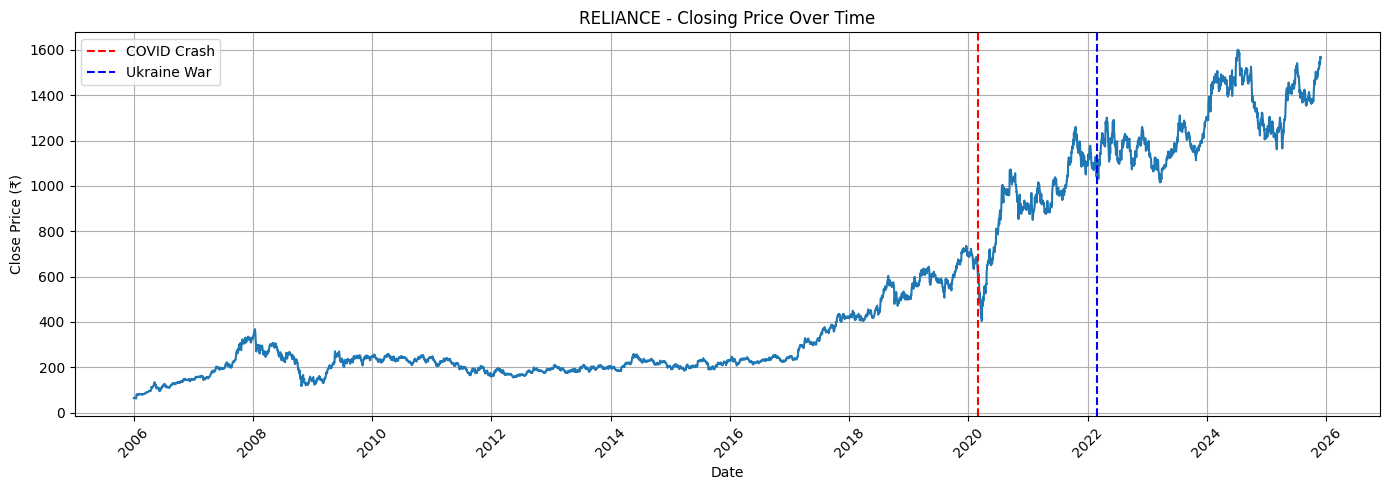

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_cleaned_final.csv")

# Filter for a specific stock
sample_stock =("RELIANCE")
sample_df = df[df["Stock"] == sample_stock].sort_values("Date")

# Ensure 'Date' column is in datetime format
sample_df["Date"] = pd.to_datetime(sample_df["Date"])

# Set a clean plot style
plt.style.use('default')

# Create the plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_df, x="Date", y="Close")

plt.title(f"{sample_stock} - Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (₹)")
plt.grid(True)

# Format X-axis to show ticks every 2 years
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Annotate major market events

plt.axvline(pd.to_datetime("2020-03-01"), color='red', linestyle='--', label='COVID Crash')
plt.axvline(pd.to_datetime("2022-02-24"), color='blue', linestyle='--', label='Ukraine War')

# Add legend
plt.legend()

# Tight layout and display
plt.tight_layout()
plt.show()


In [24]:
import ta

# Load your preprocessed dataset
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_cleaned_final.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Container for all indicator-enhanced data
enhanced_data = []

# Loop through each stock individually
for stock in df["Stock"].unique():
    stock_df = df[df["Stock"] == stock].copy()
    stock_df = stock_df.sort_values("Date")

    # Add technical indicators using `ta`
    stock_df["SMA_14"] = ta.trend.sma_indicator(stock_df["Close"], window=14)
    stock_df["EMA_14"] = ta.trend.ema_indicator(stock_df["Close"], window=14)
    stock_df["RSI_14"] = ta.momentum.rsi(stock_df["Close"], window=14)
    macd = ta.trend.macd(stock_df["Close"])
    stock_df["MACD"] = macd
    bb = ta.volatility.BollingerBands(close=stock_df["Close"], window=20, window_dev=2)
    stock_df["BB_High"] = bb.bollinger_hband()
    stock_df["BB_Low"] = bb.bollinger_lband()
    stock_df["ATR_14"] = ta.volatility.average_true_range(stock_df["High"], stock_df["Low"], stock_df["Close"], window=14)
    stock_df["Volume_SMA_14"] = ta.trend.sma_indicator(stock_df["Volume"], window=14)

    # Drop rows with NaNs caused by rolling indicators
    stock_df.dropna(inplace=True)

    # Append processed stock data
    enhanced_data.append(stock_df)

# Combine all processed stock data
df_final = pd.concat(enhanced_data, ignore_index=True)

# Save to file
output_path = "/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_with_indicators.csv"
df_final.to_csv(output_path, index=False)

print("Technical indicators added and saved to:", output_path)
print("Final dataset shape:", df_final.shape)
df_final.head()

Technical indicators added and saved to: /Users/somrajbharadwaj/project/final_data_science/stock_data/top250_with_indicators.csv
Final dataset shape: (1111327, 16)


,Date,Adj Close,Close,High,Low,Open,Volume,Stock,SMA_14,EMA_14,RSI_14,MACD,BB_High,BB_Low,ATR_14,Volume_SMA_14
0,2006-02-08,80.669426,88.966522,91.145378,88.243866,88.970154,800163.0,ABB,87.781246,86.432615,69.932397,4.458877,98.526256,68.407168,3.144599,778290.071429
1,2006-02-10,79.872566,88.087715,89.623810,86.791290,89.623810,360232.0,ABB,88.622182,86.653295,66.388441,4.205653,98.629246,69.788890,3.122307,765349.142857
2,2006-02-13,81.933838,90.360992,91.330582,88.134918,88.134918,1121248.0,ABB,89.235246,87.147655,70.546498,4.140674,98.759028,71.400200,3.130919,799491.142857
3,2006-02-14,81.942047,90.370071,92.238441,86.718658,86.718658,643475.0,ABB,89.759859,87.577311,70.562161,4.043302,98.547097,73.393712,3.301552,777596.571429
4,2006-02-15,81.833405,90.250237,91.982430,89.375053,90.313782,648729.0,ABB,89.766344,87.933701,70.032775,3.911376,98.084481,75.549486,3.251968,720325.571429


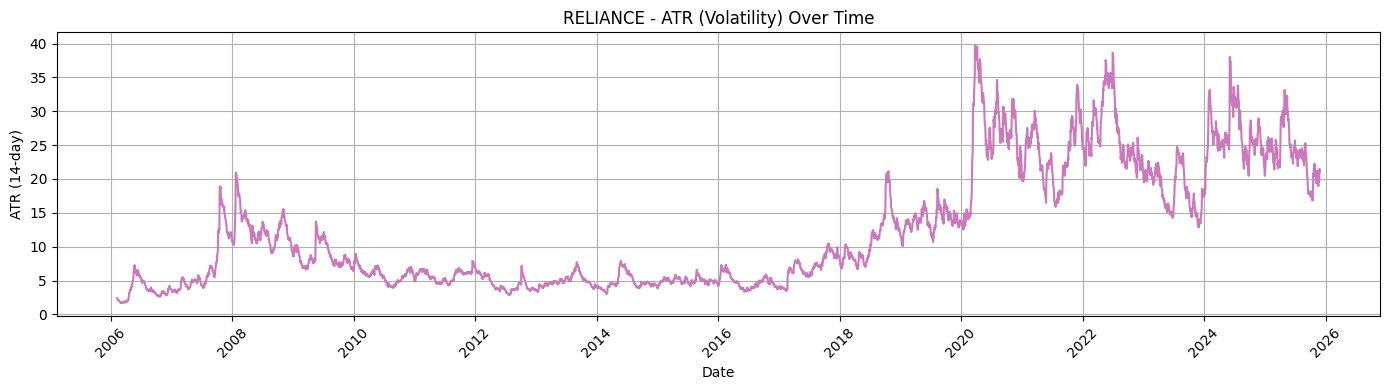

In [25]:
# Load the cleaned dataset
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_with_indicators.csv")
# Ensure Date is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Filter a Sample Stock
sample_stock = "RELIANCE"
sample_df = df[df["Stock"] == sample_stock].sort_values("Date")

# 6. Plot ATR Over Time (Volatility)

if "ATR_14" in sample_df.columns:
    plt.figure(figsize=(14, 4))
    sns.lineplot(data=sample_df, x="Date", y="ATR_14", color='#CC78BC')
    plt.title(f"{sample_stock} - ATR (Volatility) Over Time")
    plt.xlabel("Date")
    plt.ylabel("ATR (14-day)")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ATR_14 column not found. Make sure technical indicators are computed.")



In [27]:
import pandas as pd

# Load the dataset with technical indicators
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/top250_with_indicators.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Store train/test splits
train_list = []
test_list = []

# Split 80/20 for each stock chronologically
for stock in df["Stock"].unique():
    stock_df = df[df["Stock"] == stock].sort_values("Date").reset_index(drop=True)

    # Define the 80% cutoff index
    split_idx = int(len(stock_df) * 0.8)

    # Split into train and test
    train_df = stock_df.iloc[:split_idx].copy()
    test_df = stock_df.iloc[split_idx:].copy()

    train_list.append(train_df)
    test_list.append(test_df)

# Combine all stocks’ splits into final DataFrames
train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

# Save to file for modeling use
train_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/train_80.csv", index=False)
test_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/test_20.csv", index=False)

print("Data split 80/20 and saved.")
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Data split 80/20 and saved.
Train shape: (888924, 16)
Test shape: (222403, 16)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load training and testing datasets
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/train_80.csv")
test = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/test_20.csv")

# Ensure 'Date' column is in datetime format
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

# Define technical indicator features
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Create the prediction target column
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
test["Target"] = test.groupby("Stock")["Close"].shift(-1)

# Drop rows with missing values
train.dropna(subset=features + ["Target"], inplace=True)
test.dropna(subset=features + ["Target"], inplace=True)

# Feature matrix and target variable
X_train, y_train = train[features], train["Target"]
X_test, y_test = test[features], test["Target"]


# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100,
                              random_state=42)
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mse)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Save metrics for model comparison
rf_rmse = rmse
rf_mae = mae
rf_r2 = r2

# Residual distribution
residuals = y_test - preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.title("Random Forest - Residual Distribution (All Stocks)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to visualize actual vs predicted for individual stocks
def plot_stock_predictions(stock_symbol, model, test_df, feature_cols):
    stock_data = test_df[test_df["Stock"] == stock_symbol].copy()
    stock_data.dropna(subset=feature_cols + ["Target"], inplace=True)

    if stock_data.empty:
        print(f"No valid data found for {stock_symbol}")
        return

    dates = stock_data["Date"]
    actual = stock_data["Target"]
    predicted = model.predict(stock_data[feature_cols])

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Actual', linewidth=2)
    plt.plot(dates, predicted, label='Predicted', linewidth=2)
    plt.title(f"Random Forest - Actual vs Predicted Prices for {stock_symbol}")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predictions for selected companies
plot_stock_predictions("RELIANCE", model, test, features)
plot_stock_predictions("SBIN", model, test, features)
plot_stock_predictions("INFY", model, test, features)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Load training data
train = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/stock_data/train_80.csv")

# Define features and target
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
train["Target"] = train.groupby("Stock")["Close"].shift(-1)
train.dropna(subset=features + ["Target"], inplace=True)

X_train, y_train = train[features], train["Target"]

# Use time-based CV
tscv = TimeSeriesSplit(n_splits=3)

# Define a reduced search space for speed
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# File to save best model
model_path = "/Users/somrajbharadwaj/project/final_data_science/stock_data/best_random_forest_model_fast.pkl"

# If saved model exists, load it; else perform tuning and save
if os.path.exists(model_path):
    best_rf_model = joblib.load(model_path)
else:
    search = RandomizedSearchCV(
        estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
        param_distributions=param_dist,
        n_iter=20,
        cv=tscv,
        verbose=2,
        scoring='neg_mean_squared_error',
        random_state=42
    )
    search.fit(X_train, y_train)
    best_rf_model = search.best_estimator_
    joblib.dump(best_rf_model, model_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load test dataset
test = pd.read_csv("/Users/somrajbharadwaj/project/stock_data/test_20.csv")
test["Date"] = pd.to_datetime(test["Date"])

# Define features and filter date range
features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]
test["Target"] = test.groupby("Stock")["Close"].shift(-1)
test.dropna(subset=features + ["Target"], inplace=True)
test = test[(test["Date"] >= "2021-12-06") & (test["Date"] <= "2025-11-27")]

# Random Forest model
rf_model = joblib.load("/Users/somrajbharadwaj/project/stock_data/best_random_forest_model_fast.pkl")

# Stocks to evaluate
selected_stocks = ["RELIANCE", "TATAMOTORS", "INFY"]

# Store evaluation metrics
rf_metrics_list = []

for stock in selected_stocks:
    stock_df = test[test["Stock"] == stock].copy()

    if stock_df.empty:
        print(f"No data found for {stock}. Skipping...")
        continue

    X = stock_df[features]
    y_actual = stock_df["Target"]
    y_pred = rf_model.predict(X)

    # Evaluation
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    print(f"\nEvaluation for {stock} (2021–2025):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    rf_metrics_list.append({
        "Stock": stock,
        "Model": "Random Forest",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Plot: Actual vs Predicted
    plt.figure(figsize=(12, 5))
    plt.plot(stock_df["Date"], y_actual, label="Actual", linewidth=2)
    plt.plot(stock_df["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"Random Forest - {stock} Closing Price (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Close Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


    # Save residual plot
    residual_path = f"/Users/somrajbharadwaj/project/stock_data/rf_residual_plot_{stock.replace('.NS', '')}.png"
    plt.savefig(residual_path)
    plt.show()

# Save evaluation metrics to CSV
rf_metrics_df = pd.DataFrame(rf_metrics_list)
rf_metrics_csv = "/Users/somrajbharadwaj/project/stock_data/random_forest_stock_metrics.csv"
rf_metrics_df.to_csv(rf_metrics_csv, index=False)

print(f"\nRandom Forest evaluation metrics saved to: {rf_metrics_csv}")
